In [64]:
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
from metasense.data import load_board
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [39]:
BOARDS = {4, 8, 10}

In [37]:
def load(i):
    (Xtrain, Ytrain), (Xtest, Ytest) = load_board(i)
    return Xtrain

In [40]:
boards = {i: load(i) for i in BOARDS}

# Bad Data?

In [177]:
boards[8].iloc[:20]

,co,no2,o3,temperature,pressure,humidity,pt,nc
datetime,,,,,,,,
2016-08-05 21:35:00,119.847407,-6.562700,12.453504,292.0,6415.0,36.0,335.603992,245.116856
2016-08-05 21:36:00,120.300546,-8.562762,15.250466,292.0,6415.0,36.0,335.603992,245.351238
2016-08-05 21:37:00,114.336822,-7.135634,15.896318,292.0,6415.0,36.0,335.603992,245.226234
2016-08-05 21:38:00,113.430545,-8.416924,10.979502,292.0,6415.0,36.0,335.614409,245.413739
2016-08-05 21:39:00,114.628498,-8.297128,16.266122,292.0,6415.0,36.0,335.588367,245.476241
2016-08-05 21:40:00,112.456556,-8.937773,14.734825,292.0,6415.0,36.0,335.588367,245.585619
2016-08-05 21:41:00,117.909849,-11.312846,14.094180,292.0,6415.0,36.0,335.603992,245.413739
2016-08-05 21:42:00,110.589313,-7.711173,19.141209,292.0,6415.0,36.0,335.510239,245.601245
2016-08-05 21:43:00,103.690664,-10.156560,11.047212,292.0,6415.0,36.0,335.432112,245.663747


In [123]:
def plot_gas(gas):
    for board_id in BOARDS:
        boards[board_id][gas].loc['2016-08-14':'2016-08-15'].plot(label='Board %u' % board_id, alpha=0.8)
    plt.title(gas)
    plt.legend(loc='best')
    plt.show()

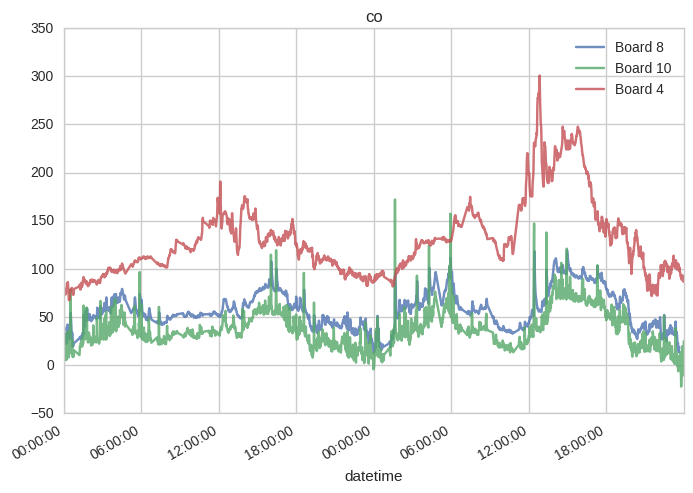

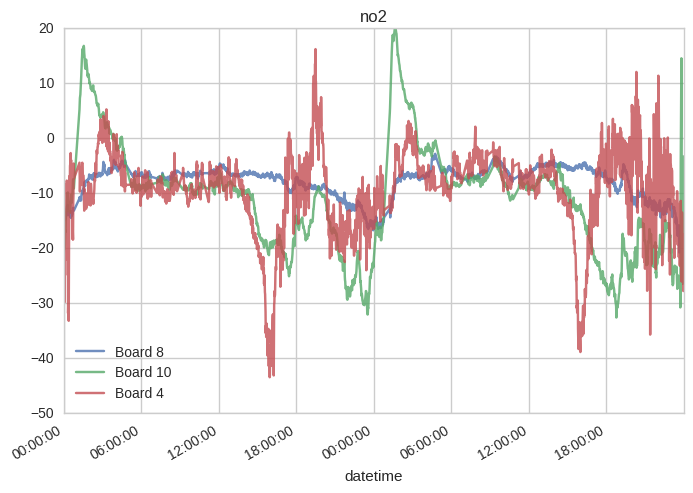

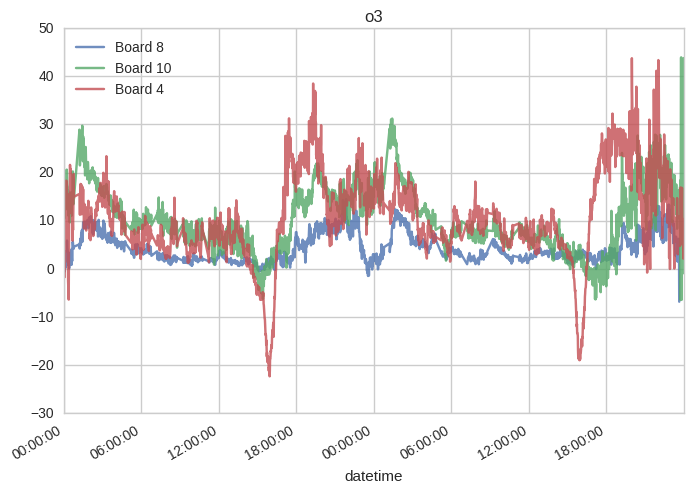

In [124]:
plot_gas('co')
plot_gas('no2')
plot_gas('o3')

In [174]:
BASE_BOARD = 4
def train_model(board_id, gas):
    data = boards[BASE_BOARD].join(boards[board_id], how='outer', lsuffix='-target', rsuffix='-base').dropna().groupby(lambda x: x.hour).mean()
    Xtrain = data[['%s-base' % gas]]
    Ytrain = data[['%s-target' % gas]]
    cf = LinearRegression()
    cf.fit(np.array(Xtrain), np.array(Ytrain))
    return cf
    
def plot_model(board_id, gas):
    cf = train_model(board_id, gas)
    base_data = boards[BASE_BOARD].join(boards[board_id], how='outer', lsuffix='-target', rsuffix='-base').dropna()
    dates = slice('2016-08-6', '2016-08-8')
    base_data['%s-pred' % gas] = cf.predict(base_data[['%s-base' % gas]])
    base_data['%s-base' % gas].loc[dates].plot(label='previous')

    base_data['%s-target' % gas].loc[dates].plot(label='actual')
    base_data['%s-pred' % gas].loc[dates].plot(label='predicted')
    plt.legend(loc='best')
    plt.title("Board %u - %s" % (board_id, gas))
    plt.show()
    print("Weight:", cf.coef_[0, 0], "Intercept:", cf.intercept_[0])
    
    #return base_data

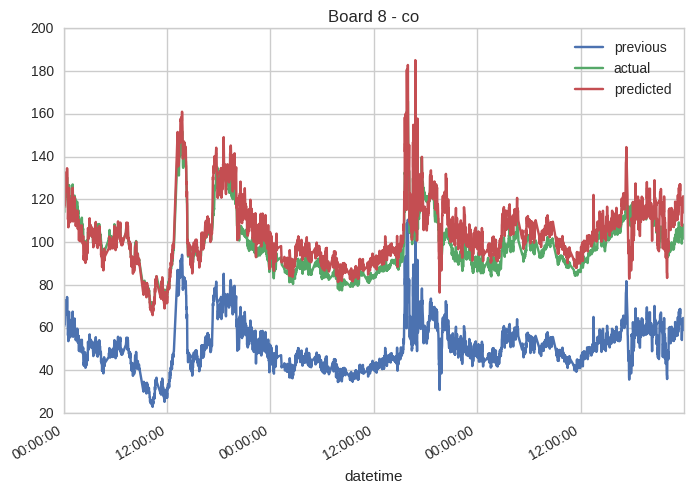

Weight: 1.33743634211 Intercept: 35.1211914091


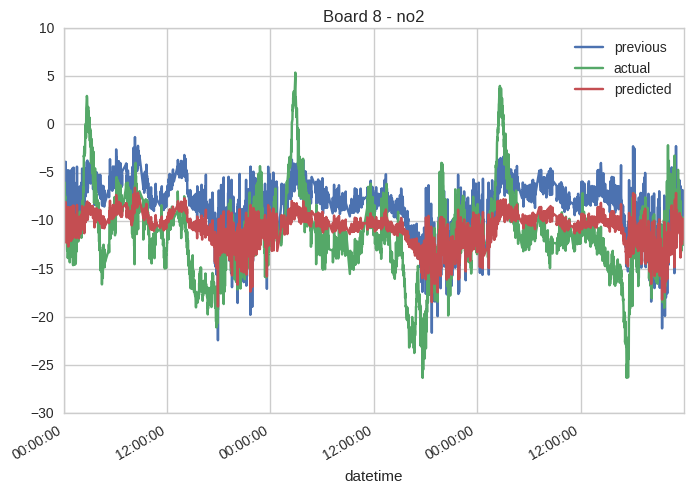

Weight: 0.584182846955 Intercept: -5.81017267546


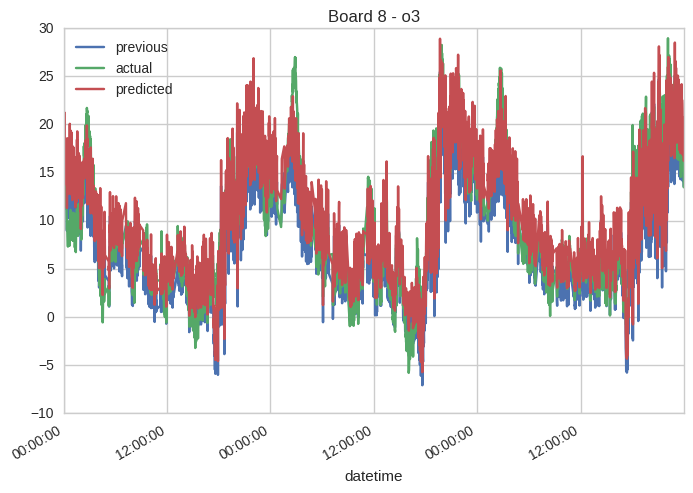

Weight: 1.06371578148 Intercept: 1.81429454334


In [175]:
plot_model(8, 'co')
plot_model(8, 'no2')
plot_model(8, 'o3')

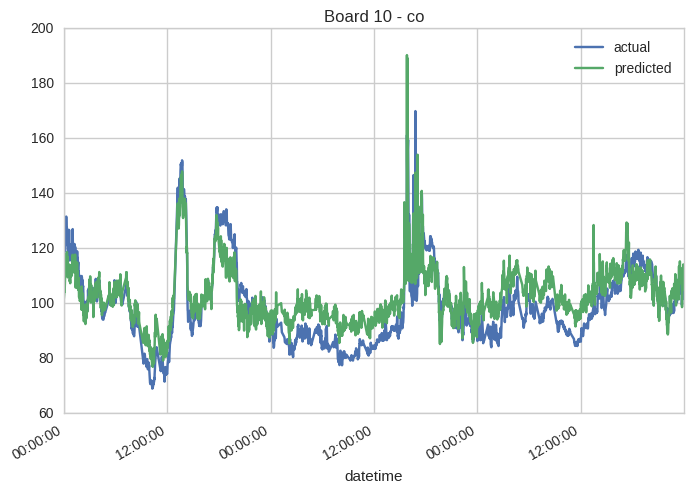

Weight: 1.14796610266 Intercept: 71.5666578006


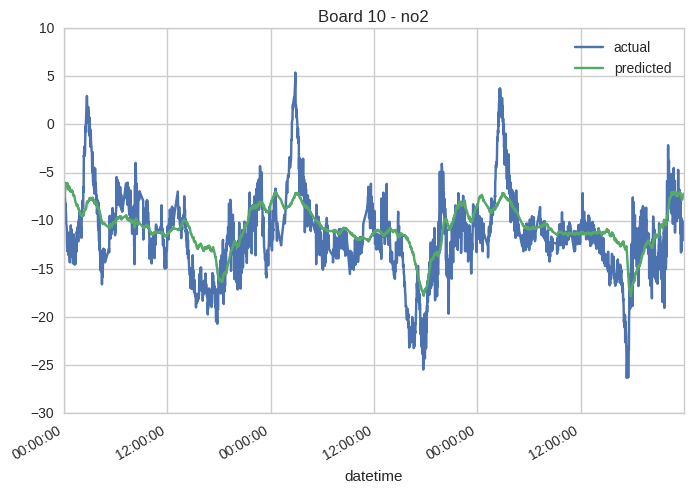

Weight: 0.299073407783 Intercept: -7.56209151352


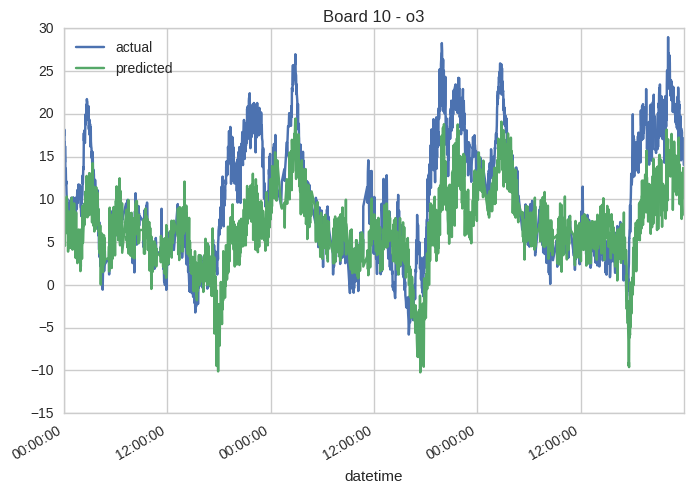

Weight: 1.09110058745 Intercept: 4.84373486296


In [173]:
plot_model(10, 'co')
plot_model(10, 'no2')
plot_model(10, 'o3')